In [1]:
# Enable module reloading
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import math
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import sys
sys.path.insert(1, '../')

from src import preprocessing as pp
from src import analysis

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [3]:
train = pd.read_csv('../data/train.csv', index_col=0)
val = pd.read_csv('../data/val.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

In [4]:
X_train, y_train = train.drop('rating', axis=1), train['rating']
X_val, y_val = val.drop('rating', axis=1), val['rating']
X_test, y_test = test.drop('rating', axis=1), test['rating']

In [5]:
def print_metrics(y_true, y_pred):
    print("MSE:", mean_squared_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    fig, axs = plt.subplots(nrows=3, figsize=(12, 15))
    data = pd.DataFrame({'y_true':y_true, 'y_pred': y_pred, 'diff': abs(y_pred - y_true)})
    sns.boxplot(x="y_true", y="y_pred", data=data, ax=axs[0])
    sns.boxplot(x="y_true", y="diff", data=data, ax=axs[1])
    sns.distplot(y_true, ax=axs[2])

# Dummy approach - using mean as prediction

MSE: 1.0145113423044165
RMSE: 1.0072295380420575
MAE: 0.7590087698900732


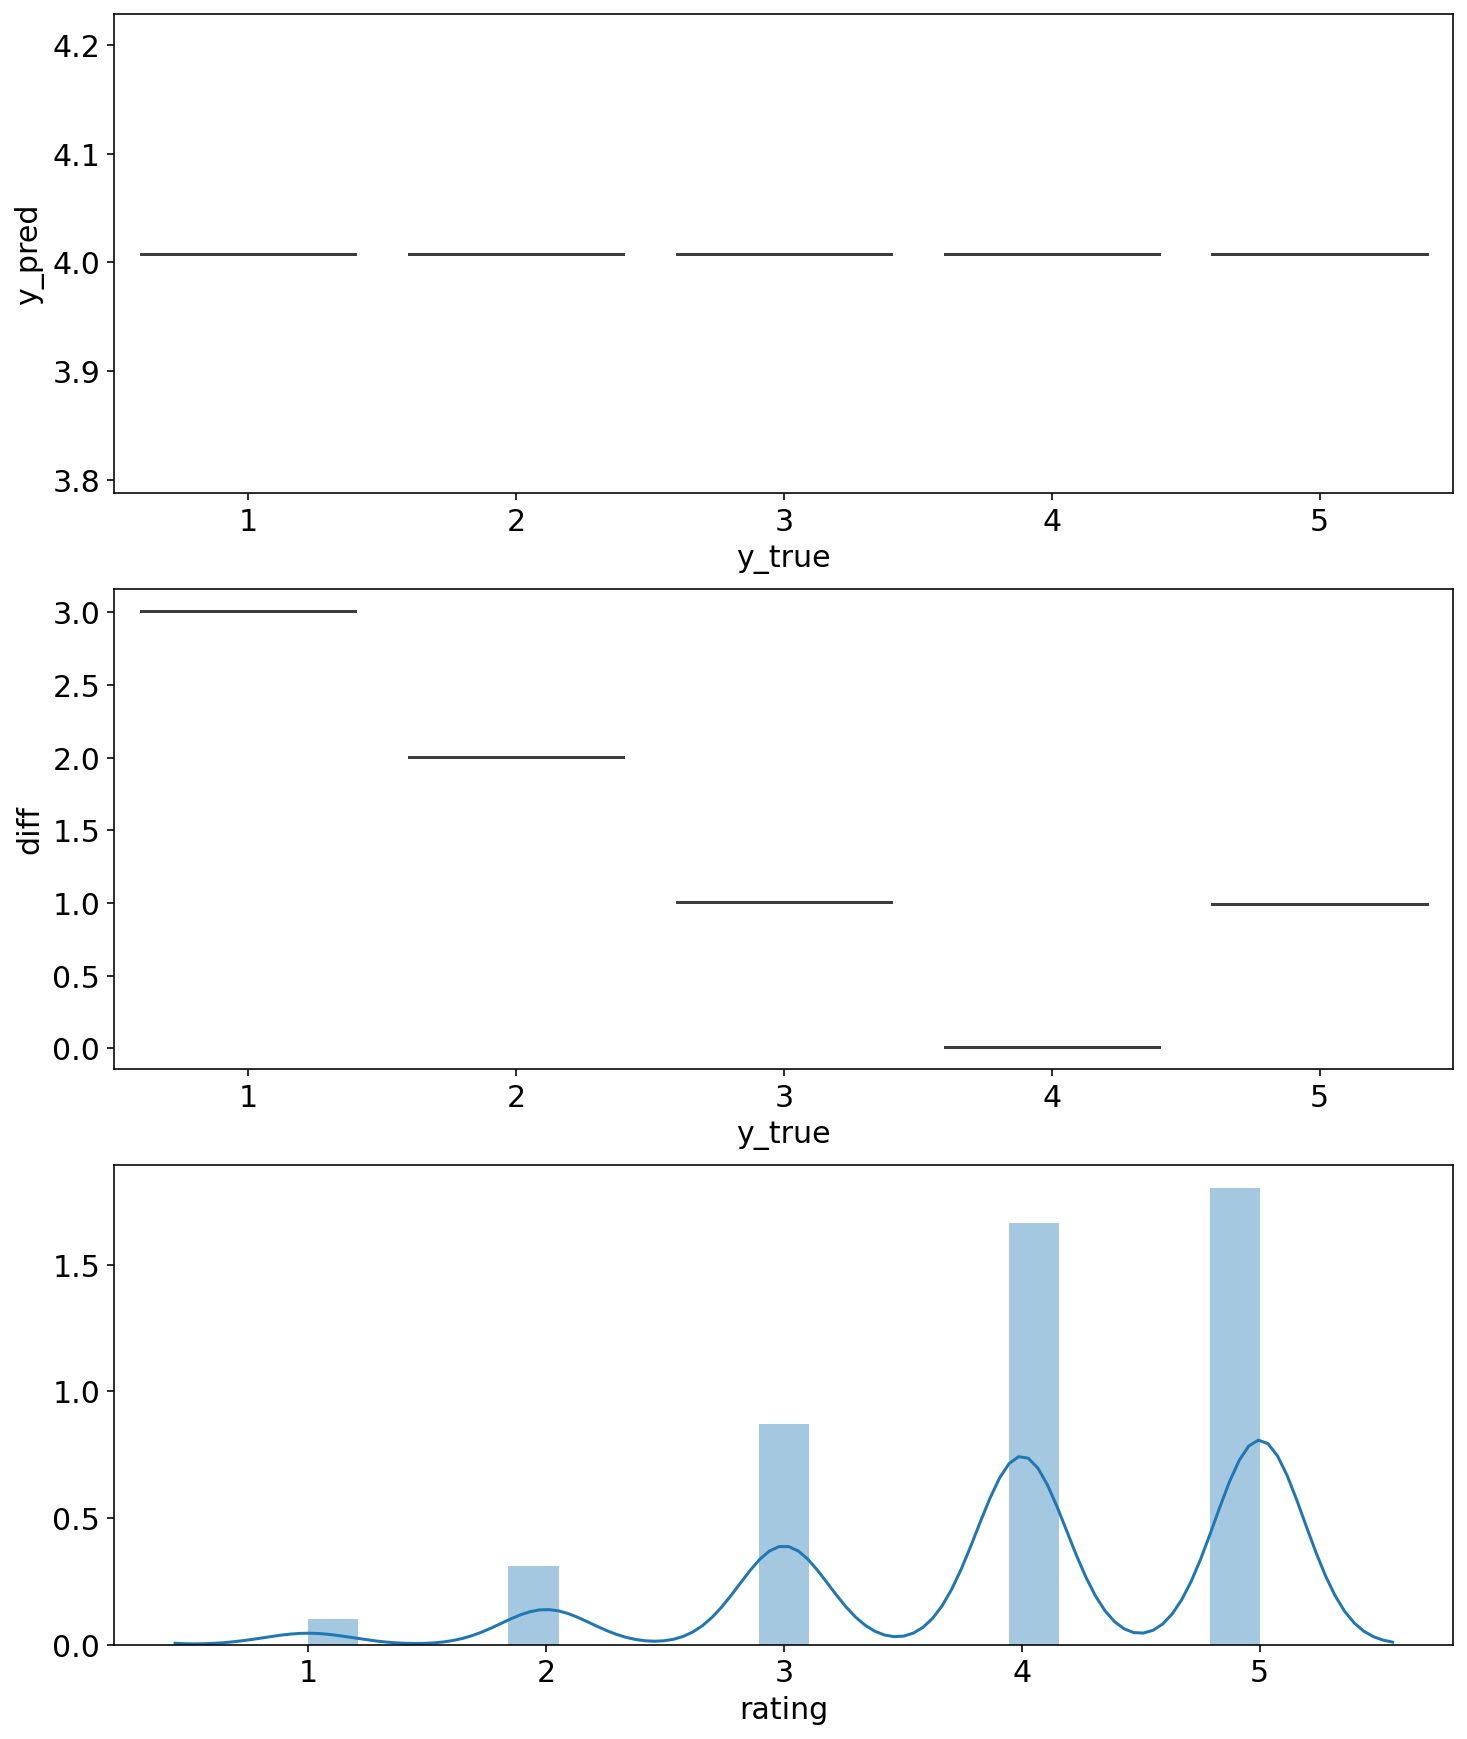

In [6]:
print_metrics(y_val, [y_train.mean()] * y_val.shape[0])

# Linear regression

In [7]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_val)

MSE: 0.8666845367973921
RMSE: 0.9309589340015982
MAE: 0.7399364455471942


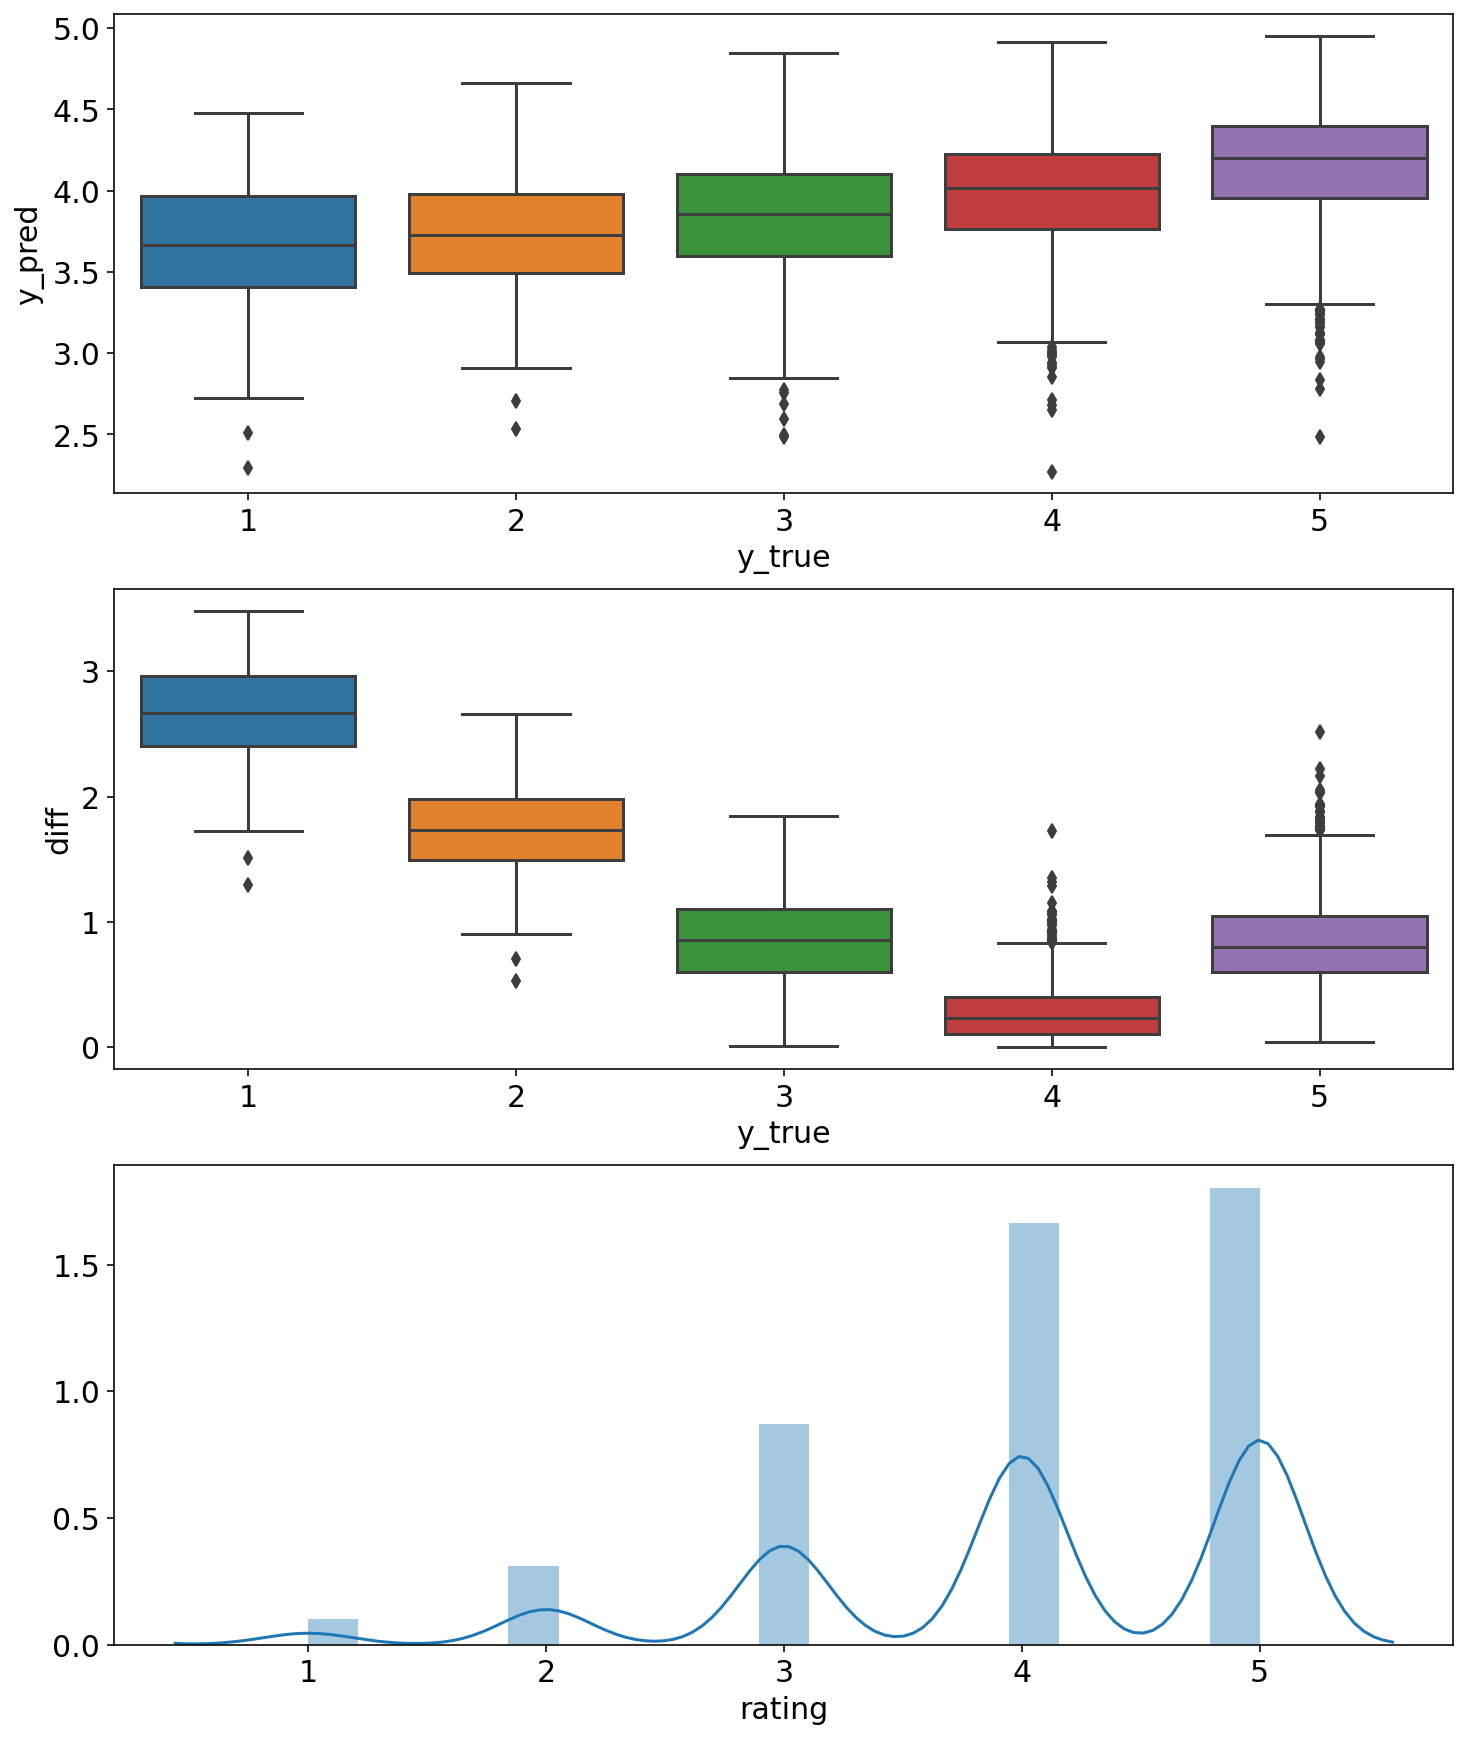

In [8]:
print_metrics(y_val, y_pred)

# Polynomial regression

In [11]:
polynomial_features= PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X_train)

model = LinearRegression()
model.fit(x_poly, y_train)

x_poly = polynomial_features.transform(X_val)
y_pred = model.predict(x_poly)

MSE: 0.8628862066626743
RMSE: 0.9289166844570477
MAE: 0.7384850274822298


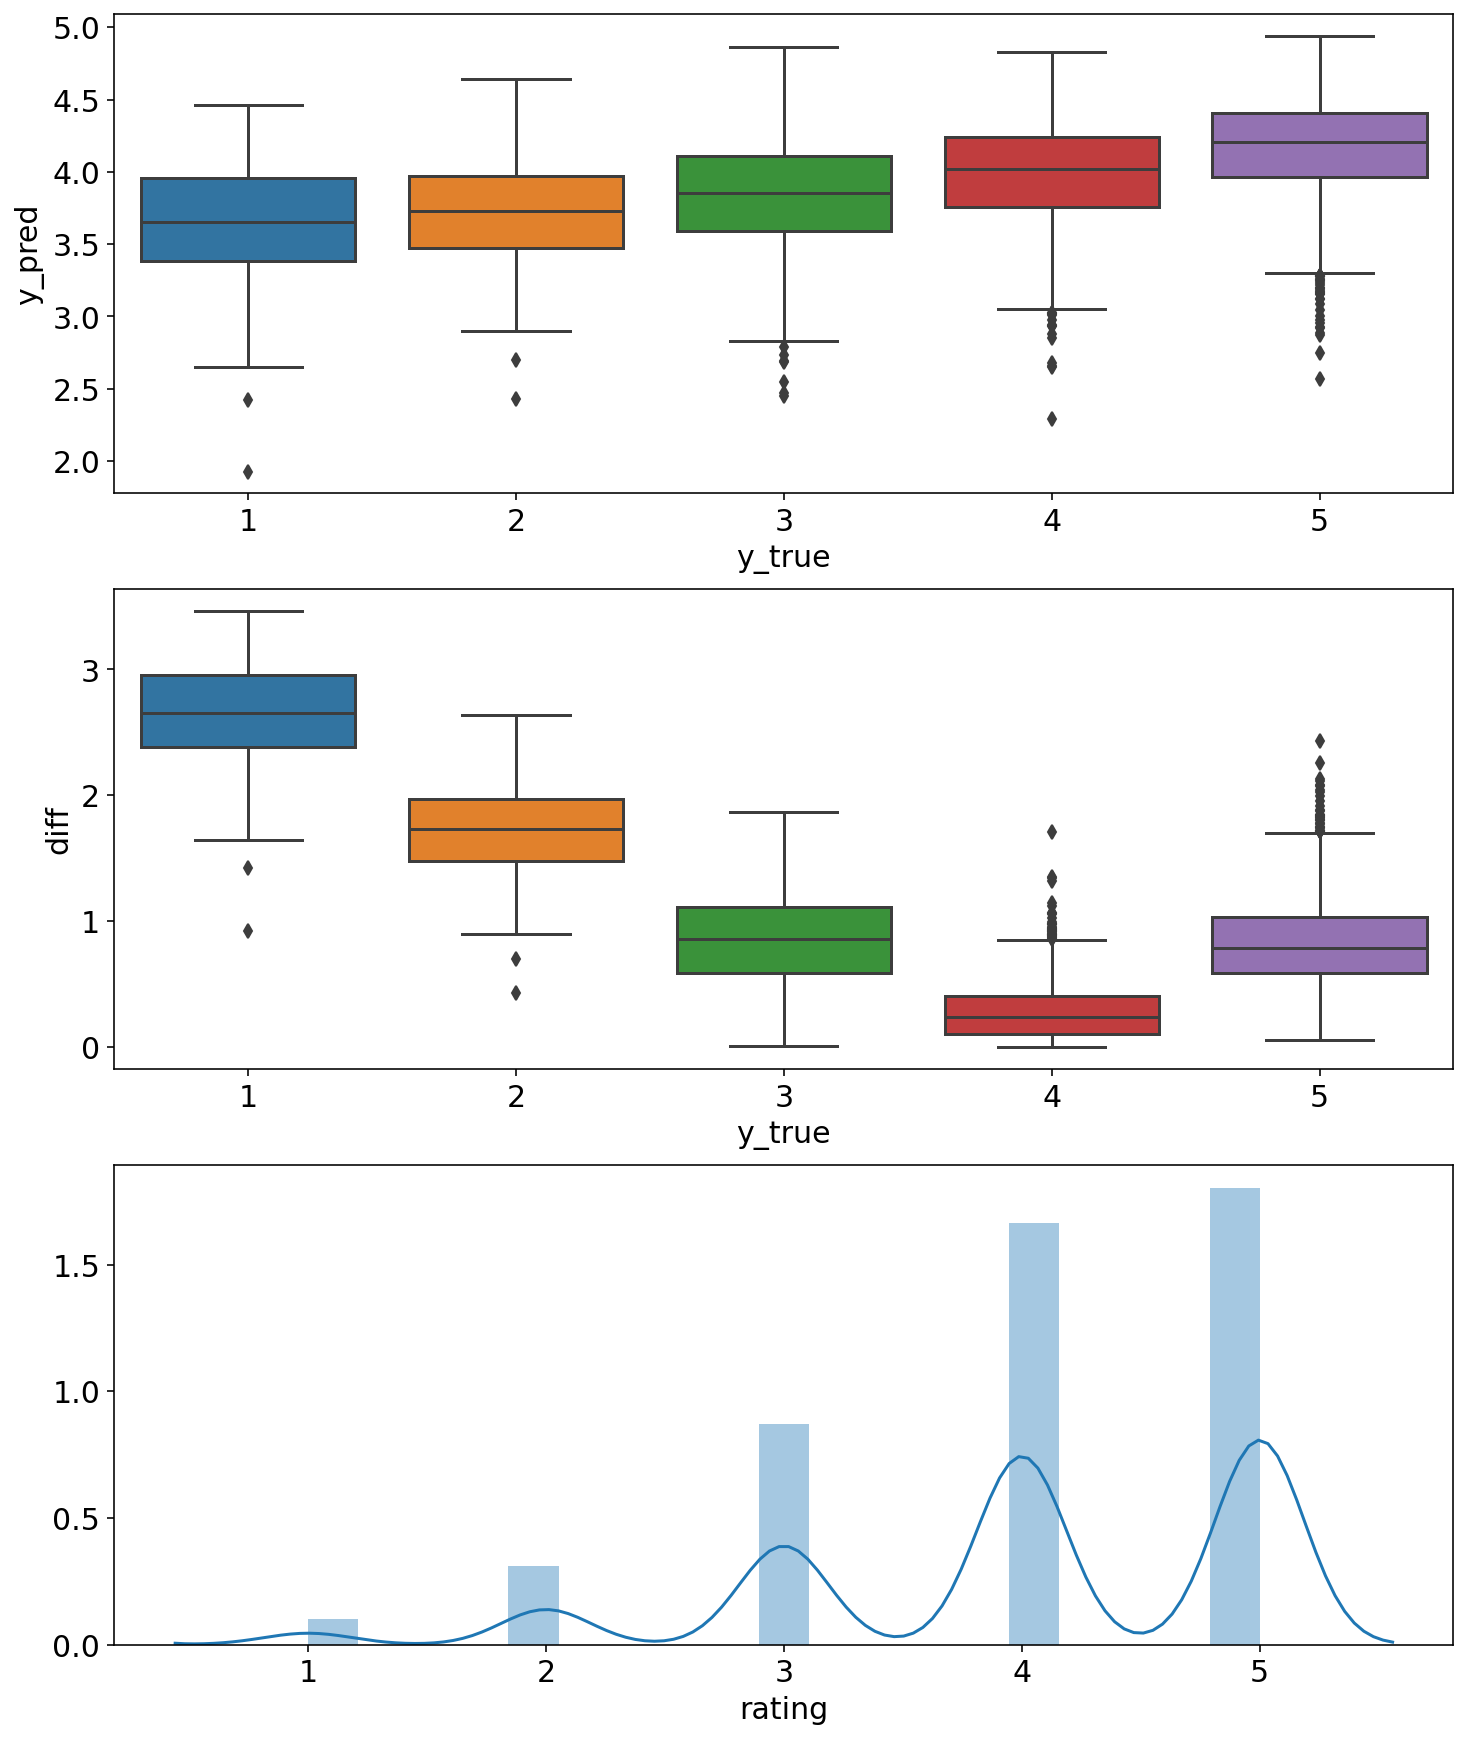

In [12]:
print_metrics(y_val, y_pred)

# Random forest regression

In [35]:
regr = RandomForestRegressor(max_depth=10, random_state=0)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

MSE: 0.8695409356326941
RMSE: 0.9324917885068448
MAE: 0.7311878714927378


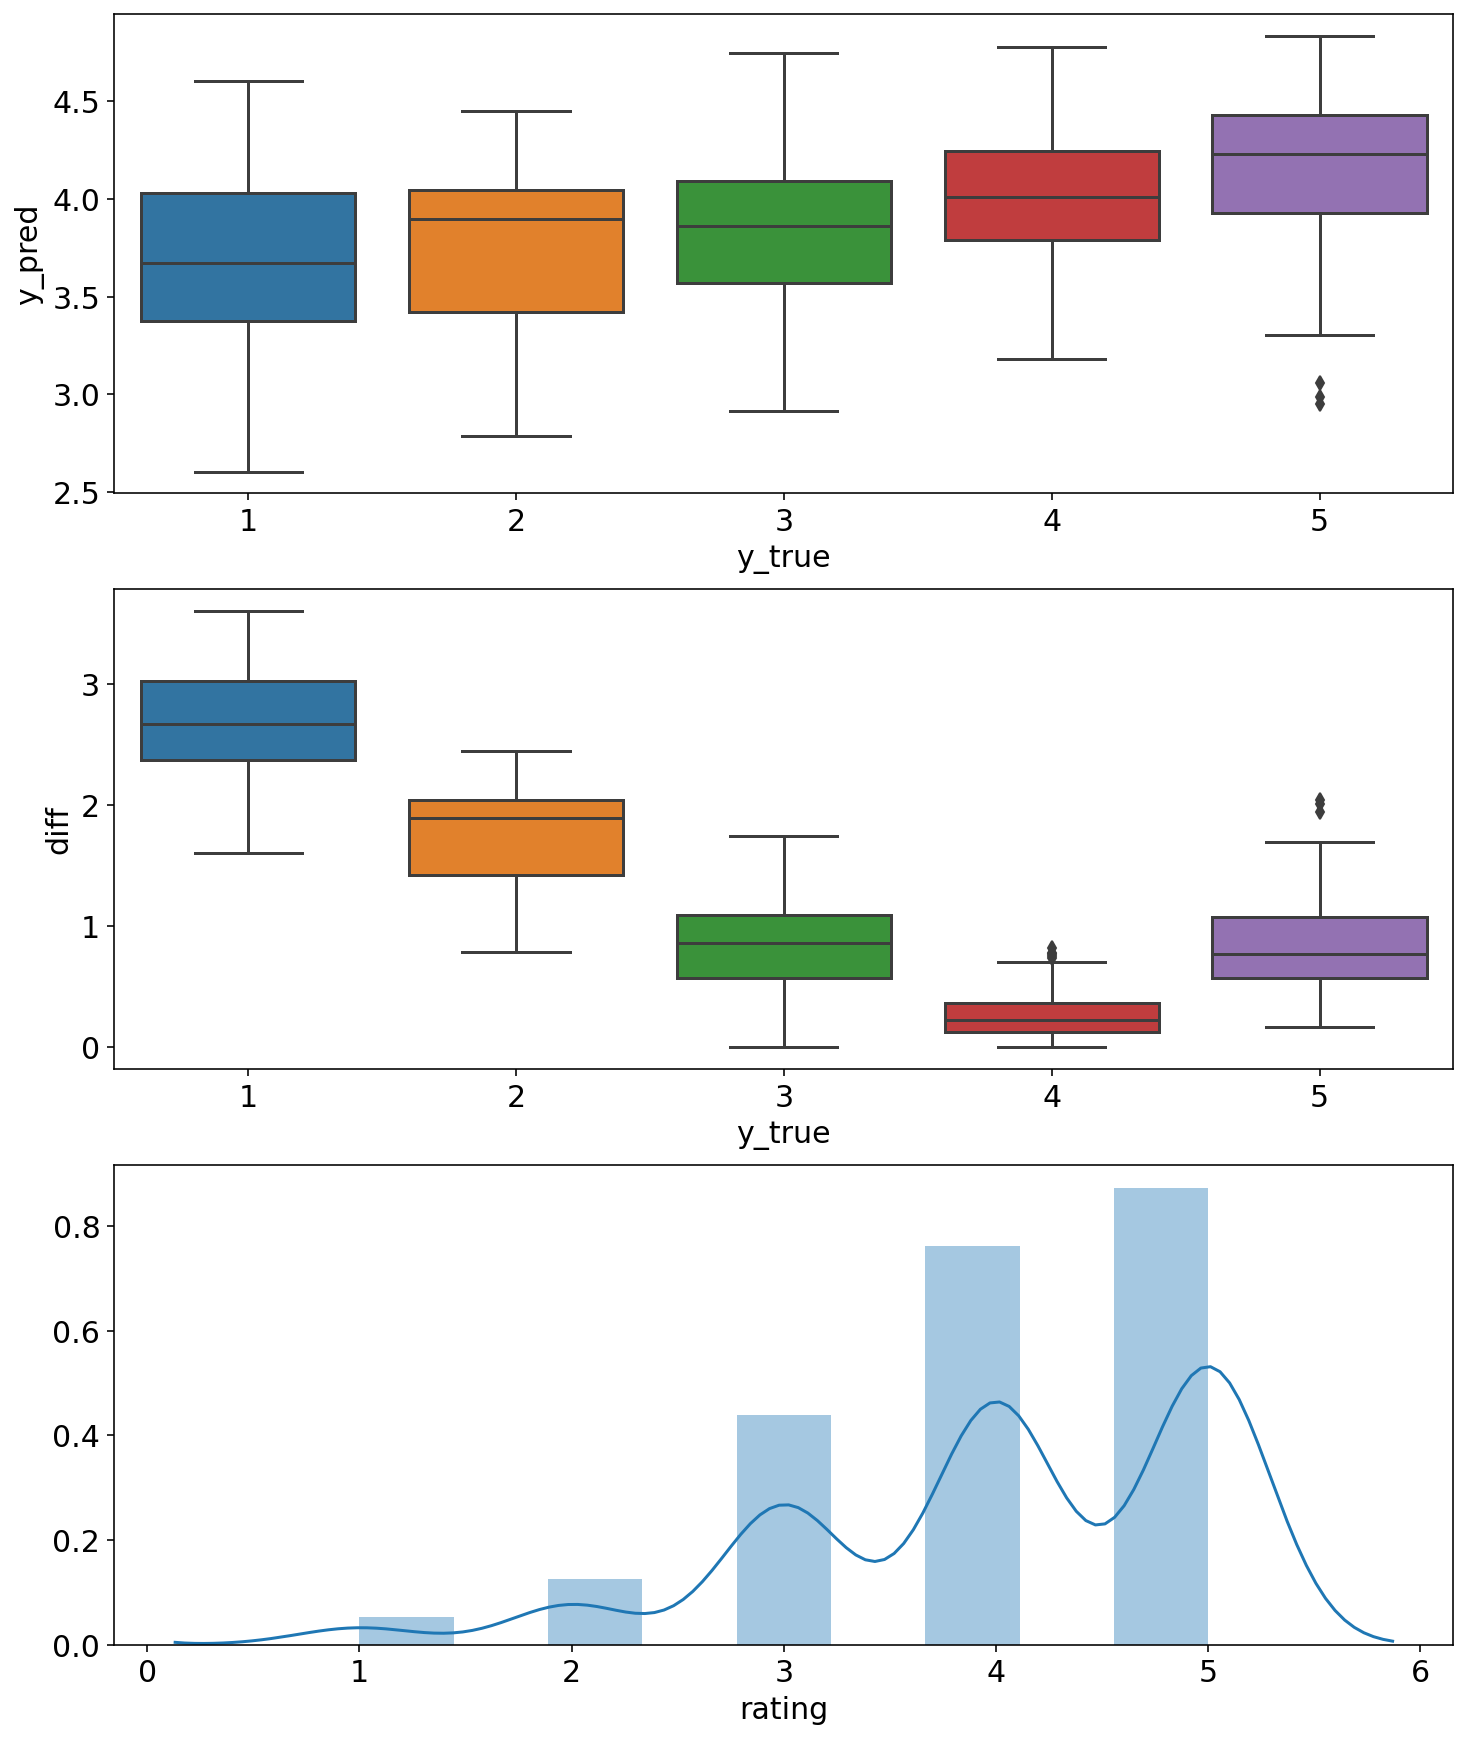

In [37]:
print_metrics(y_test, y_pred)

# Feature selection

## Feature importances

In [50]:
regr.feature_importances_

array([0.00652225, 0.69124365, 0.00730792, 0.0068646 , 0.22252127,
       0.02228519, 0.01462865, 0.01471028, 0.01391619])

In [52]:
X_train.columns

Index(['text_reviews_count', 'rating_book_avg', 'text_reviews_count_sim_avg',
       'rating_sim_avg', 'book_rating_sim_avg', 'neg_sim_avg', 'neu_sim_avg',
       'pos_sim_avg', 'compound_sim_avg'],
      dtype='object')

In [29]:
X_train

,text_reviews_count,rating_book_avg,text_reviews_count_sim_avg,rating_sim_avg,book_rating_sim_avg,neg_sim_avg,neu_sim_avg,pos_sim_avg,compound_sim_avg
793543,995.0,3.782890,675.4,4.133263,4.0,0.034567,0.026833,0.938333,0.034833
1403930,166.0,4.191278,2701.4,3.678843,4.0,-0.079950,0.089500,0.649000,0.261500
1163489,340.0,4.510526,1036.0,4.034377,3.0,0.275233,0.069000,0.802667,0.128667
450851,250.0,4.138810,420.6,3.731955,3.0,0.116237,0.058375,0.828875,0.112625
1748176,281.0,4.026832,353.0,3.582408,4.0,0.051306,0.054750,0.877938,0.067250
...,...,...,...,...,...,...,...,...,...
877041,906.0,3.779851,729.8,3.918518,5.0,0.427510,0.094300,0.706500,0.199000
1220567,4548.0,3.851064,1048.4,3.968954,3.0,-0.684200,0.182000,0.762000,0.056000
458229,266.0,4.204797,736.8,3.783912,4.0,0.196000,0.070692,0.752795,0.176513
2265603,171.0,3.580769,530.2,3.854014,5.0,0.053481,0.087833,0.819143,0.093048


# Sequential feature selection

In [33]:
reg = LinearRegression()
regr = RandomForestRegressor(max_depth=3, random_state=0)

sfs1 = SFS(regr,
           k_features="best",
           forward=True,
           floating=False,
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=2,
           n_jobs=-1)
sfs1 = sfs1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.2min remaining:   35.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.2min finished

[2020-05-16 20:20:11] Features: 1/9 -- score: -0.9077039411602881[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  1.4min remaining:   50.7s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.5min finished

[2020-05-16 20:21:42] Features: 2/9 -- score: -0.8859627166747299[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  1.6min finished

[2020-05-16 20:23:17] Features: 3/9 -- score: -0.8859627166747299[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of

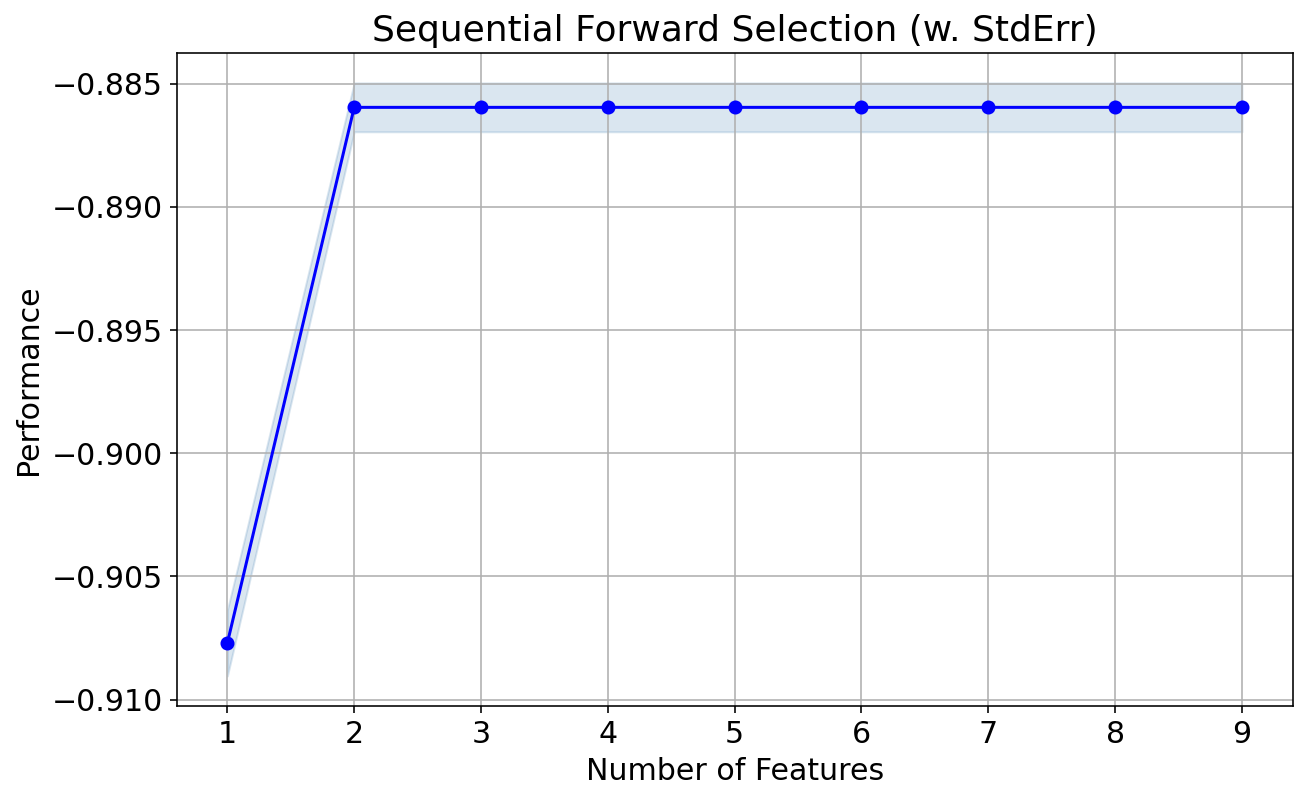

In [34]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
sfs1.subsets_

# Hyperparameter tuning

In [53]:
ind_params = {'random_state': 0}

random_params = {
    'n_estimators': range(3,30),
    'criterion': ['mse', 'mae'],
    'max_depth': [i for i in range(1, 30)] + [None],
    'min_samples_leaf': range(1,10),
    'max_features': ['auto', 'sqrt', 'log2']
}

clf = RandomForestRegressor

In [71]:
random_optimization = RandomizedSearchCV(clf(**ind_params), param_distributions = random_params, 
                               n_iter = 100, scoring = 'neg_mean_squared_error', cv = 5, verbose=True,
                                         random_state=42, n_jobs = -1)

In [ ]:
random_optimization.best_estimator_

In [ ]:
np.sort(random_optimization.cv_results_['mean_test_score'])[-10:]

In [ ]:
indexes = np.argsort(random_optimization.cv_results_['mean_test_score'])[-10:]

for x in indexes:
    print(random_optimization.cv_results_['params'][x], random_optimization.cv_results_['mean_test_score'][x])

In [90]:
random_optimization.fit(X_train[:10000], y_train[:10000])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 21.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [91]:
random_optimization.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=22, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [97]:
np.sort(random_optimization.cv_results_['mean_test_score'])[-10:]

array([-0.88691925, -0.88485562, -0.88426062, -0.8834162 , -0.88158929,
       -0.88126919, -0.88043085, -0.8772687 , -0.8771418 , -0.8764933 ])

In [98]:
indexes = np.argsort(random_optimization.cv_results_['mean_test_score'])[-10:]

for x in indexes:
    print(random_optimization.cv_results_['params'][x], random_optimization.cv_results_['mean_test_score'][x])

{'n_estimators': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'mse'} -0.8869192515421
{'n_estimators': 23, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'mse'} -0.8848556157261058
{'n_estimators': 25, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'mse'} -0.8842606236266942
{'n_estimators': 23, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 4, 'criterion': 'mse'} -0.8834161970283189
{'n_estimators': 27, 'min_samples_leaf': 3, 'max_features': 'log2', 'max_depth': 9, 'criterion': 'mse'} -0.8815892941709009
{'n_estimators': 22, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'mse'} -0.8812691870684526
{'n_estimators': 23, 'min_samples_leaf': 6, 'max_features': 'auto', 'max_depth': 8, 'criterion': 'mse'} -0.880430848309838
{'n_estimators': 14, 'min_samples_leaf': 9, 'max_features': 'auto', 'max_depth': 3, 'criterion': 'mse'} -0.8772686970711667
{'n_estimat

In [23]:
regr = RandomForestRegressor(n_estimators= 22, min_samples_leaf=8, max_features= 'auto',
                             max_depth=9, criterion='mse', random_state=0)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_val[:10000])

MSE: 0.8772104571253644
RMSE: 0.9365951404557704
MAE: 0.7403076472704576


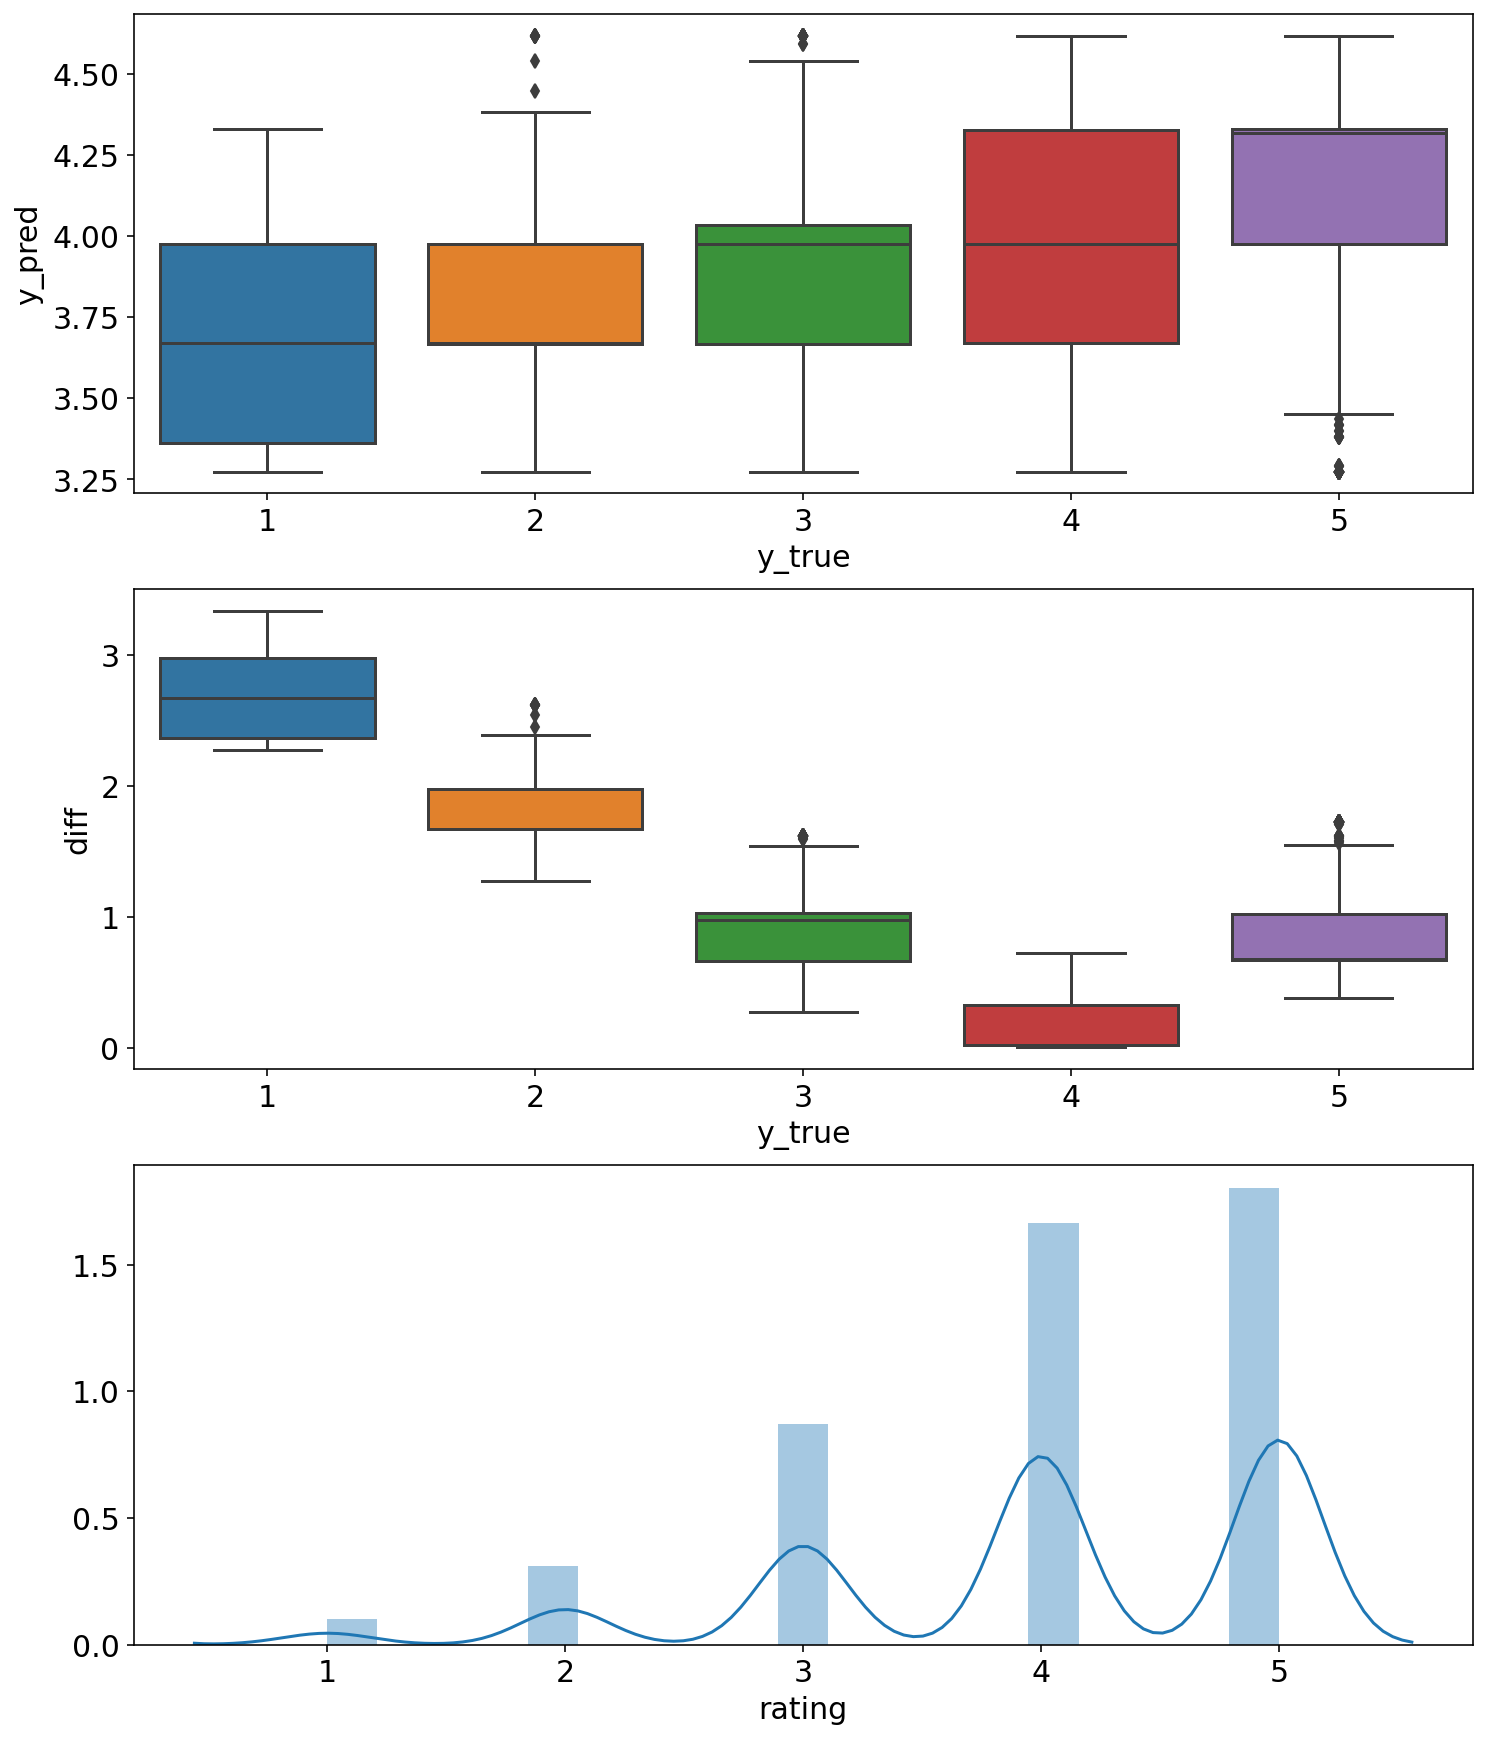

In [22]:
print_metrics(y_val, y_pred)